# Solving optimal control problems with policy gradient method 

In [8]:
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.patches as patches
font = font_manager.FontProperties(style='normal', size=20)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.set_default_dtype(torch.float32) # improved the speed when the parameters are float32
import random

import json

from IPython.display import display, Math, Markdown

import datetime
import os
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
timestamp
version = '_0.1.0'
import math
PI = math.pi

## Defining control by a neural network

$$\phi(t,x;\theta)$$



In [105]:
num_neurons = 20 # Modify the number of neurons

model = torch.nn.Sequential(
            torch.nn.Linear(2, num_neurons),
            torch.nn.ReLU(),
            torch.nn.Linear(num_neurons,1),
        )

## Predefine global variables

In [106]:
N = 10 # number of time steps
T = 1.0 # terminal time
dt = T/N # time step
num_samples = 1_000 # Modify the number of samples
x0 = 2*torch.rand([num_samples,1]) -1 # initial condition uniformly random in [-1,1]
dW = torch.sqrt(torch.tensor(dt))*torch.randn([num_samples,N,1]) # Brownian increments

## State variable

$$dX_t = (x_t-u_t)dt + dW_t$$

$$u_t=\phi(t,x_t,\theta)$$

In [107]:
# update function evolution of the state over time
def update(t,x,u):
    return x + (x -  u)*dt + dW[:,t,:]

## Loss function 

$$C(x,u)=x^2+x+u^2$$

$$g(x)=x^2-x$$

In [108]:
def step_loss(t,x,model):
    # fix concatinate t and x before plugging it into the model
    T = torch.ones_like(x)*t*dt
    tx = torch.concat((T,x),dim=1)
    u = model(tx)
    return torch.mean(x**2+x+u**2)*dt

def total_loss(model):
    x = x0
    running_cost = 0.0
    for t in range(N):
        # fix concatinate t and x before plugging it into the model
        T = torch.ones_like(x)*t*dt
        tx = torch.concat((T,x),dim=1)
        u = model(tx)
        running_cost = running_cost + step_loss(t,x,model)
        x = update(t,x,u)
    terminal_cost = torch.mean(x**2 - x)
    total_loss = running_cost + terminal_cost
    return total_loss

## Training the model (control)

In [109]:
num_epochs = 100
learning_rate = 1e-2
# optimizer = optim.Adam(model.parameters(), learning_rate)
optimizer = optim.SGD(model.parameters(), learning_rate,momentum=0.9)
loss_history = []
for e in range(num_epochs):
    loss = total_loss(model)#.clone().detach().requires_grad_(True)
    optimizer.zero_grad() # Zero the gradients before running the backward pass.
    loss.backward() # Backward pass: compute gradient of the loss with respect to all the learnable parameters
    loss_history.append(loss.item())
    if e % (num_epochs//10) == 0:
        print(e+1, loss)
    optimizer.step() # Update the weights and biases using gradient descent. Each parameter is a Tensor. Equivalent to the above three lines, but more efficient.

1 tensor(5.6927, grad_fn=<AddBackward0>)
11 tensor(2.6294, grad_fn=<AddBackward0>)
21 tensor(2.6715, grad_fn=<AddBackward0>)
31 tensor(2.4921, grad_fn=<AddBackward0>)
41 tensor(2.4447, grad_fn=<AddBackward0>)
51 tensor(2.4461, grad_fn=<AddBackward0>)
61 tensor(2.4288, grad_fn=<AddBackward0>)
71 tensor(2.4242, grad_fn=<AddBackward0>)
81 tensor(2.4196, grad_fn=<AddBackward0>)
91 tensor(2.4155, grad_fn=<AddBackward0>)


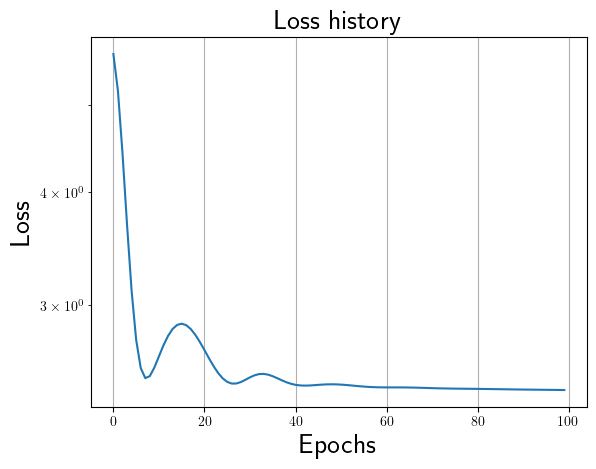

In [110]:
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Epochs',fontproperties=font)
plt.ylabel('Loss',fontproperties=font)
plt.title('Loss history',fontproperties=font)
plt.grid()
plt.show()

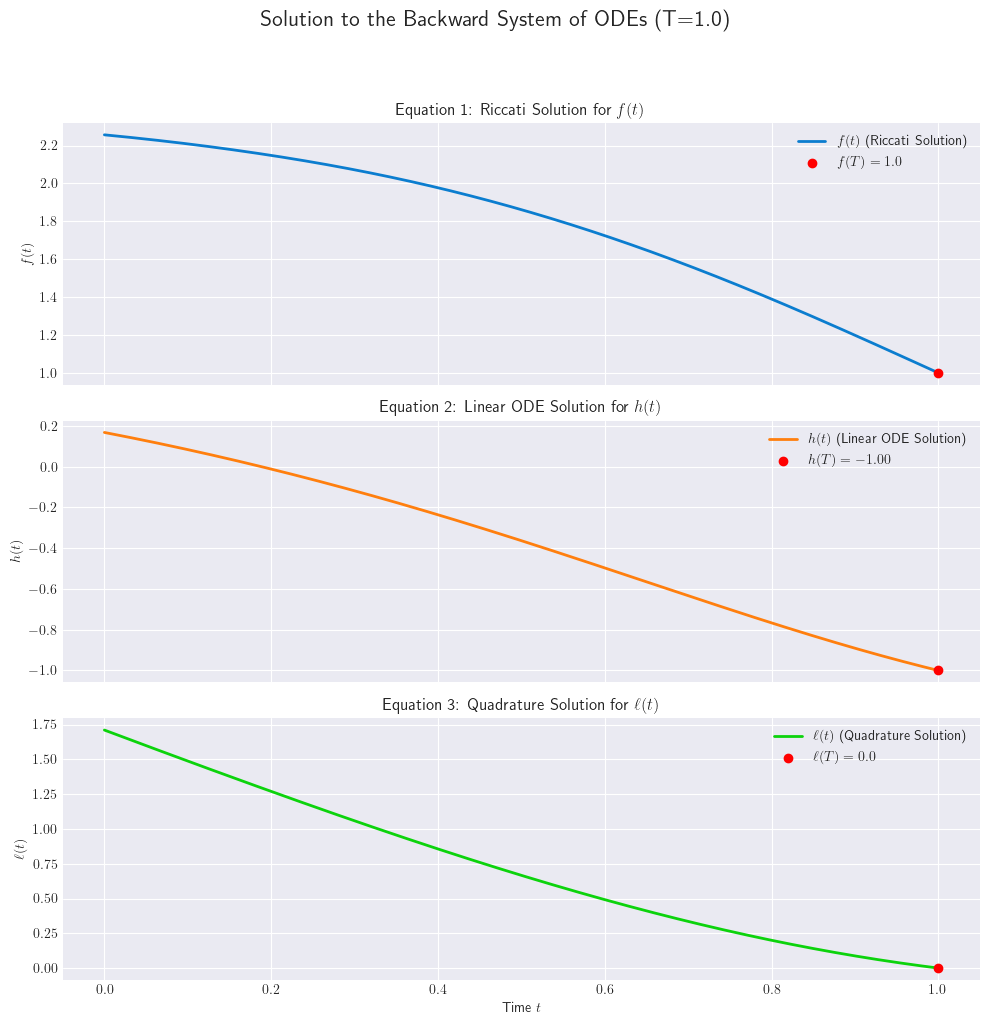

The solution was integrated successfully from t=0 to t=T=1.0.
Initial Values (at t=0):
  f(0) = 2.2564
  h(0) = 0.1683
  l(0) = 1.7109
Terminal Values (at t=T):
  f(T) = 1.0000 (Matches alpha=1.0)
  h(T) = -1.0000 (Matches beta=-1.0)
  l(T) = 0.0000 (Matches l_T=0.0)


In [18]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# --- 1. Define Constants and Terminal Conditions ---

# Constants (Placeholder values for a numerical example)
# Note: The stability of the solution depends heavily on these values.
CONSTANTS = {
    'T': 1.0,     # Final Time
    'gamma': 1.0, # Coefficient for f(t) and h(t)
    'kappa': -1.0, # Coupling coefficient (non-linear term)
    'A': 1.0,     # Quadratic cost factor in f'(t) and l'(t)
    'a': 1.0,     # Constant term in f'(t)
    'B': 0.0,     # Coupling coefficient in h'(t) and l'(t)
    'b': 1.0,     # Constant term in h'(t)
    'sigma': 1.0  # Volatility factor in l'(t)
}

# Terminal Conditions (which become Initial Conditions for the backward integration)
INITIAL_CONDITIONS = {
    'alpha': 1.0, # f(T)
    'beta': -1.0,  # h(T)
    'l_T': 0.0    # l(T)
}

# --- 2. Define the Transformed ODE System (for forward integration in tau) ---

def system_ode(tau, y, consts):
    """
    The transformed system of ODEs dY/d(tau).
    
    Y = [f(tau), h(tau), l(tau)]
    tau = T - t (Backward time variable)
    
    Since d/d(tau) = -d/dt, we negate the original expressions.
    """
    f, h, l = y
    
    # Unpack constants
    T = consts['T']
    gamma = consts['gamma']
    kappa = consts['kappa']
    A = consts['A']
    a = consts['a']
    B = consts['B']
    b = consts['b']
    sigma = consts['sigma']

    # --- Original ODEs (df/dt, dh/dt, dl/dt) ---
    
    # 1. Riccati equation for f(t) (independent)
    # f'(t) = (kappa^2 / A) * f^2 - 2*gamma*f - a
    df_dt = (kappa**2 / A) * f**2 - 2 * gamma * f - a
    
    # 2. Linear ODE for h(t) (depends on f)
    # h'(t) = ( (kappa^2 / A) * f - gamma) * h + (B*kappa / A) * f - b
    dh_dt = ((kappa**2 / A) * f - gamma) * h + (B * kappa / A) * f - b
    
    # 3. Quadrature for l(t) (depends on f and h)
    # l'(t) = 1/(4A) * (B + kappa*h)^2 - sigma^2 * f
    dl_dt = (1 / (4 * A)) * (B + kappa * h)**2 - sigma**2 * f
    
    # --- Transformed ODEs (df/d(tau), dh/d(tau), dl/d(tau)) ---
    # Since d/d(tau) = -d/dt, we negate the time derivatives
    df_dtau = -df_dt
    dh_dtau = -dh_dt
    dl_dtau = -dl_dt
    
    return [df_dtau, dh_dtau, dl_dtau]

# --- 3. Run the Solver ---

# Initial conditions for the forward integration (at tau=0, which is t=T)
y0 = [INITIAL_CONDITIONS['alpha'], 
      INITIAL_CONDITIONS['beta'], 
      INITIAL_CONDITIONS['l_T']]

# Time span for tau (from 0 to T)
tau_span = [0, CONSTANTS['T']]

# Solve the system
sol = solve_ivp(
    system_ode, 
    tau_span, 
    y0, 
    args=(CONSTANTS,), 
    method='RK45', 
    dense_output=True,
    # Solve at specific points to ensure smooth plots
    t_eval=np.linspace(0, CONSTANTS['T'], 500) 
)

# --- 4. Transform Results back to Real Time (t) ---

# Time array for the plot (t = T - tau)
T = CONSTANTS['T']
t_values = T - sol.t
# Reverse the time array so it runs from t=0 to t=T
t_values = t_values[::-1]

# Extract and reverse the solution arrays
f_t = sol.y[0][::-1]
h_t = sol.y[1][::-1]
l_t = sol.y[2][::-1]


# --- 5. Plot the Results ---

plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
fig.suptitle(f'Solution to the Backward System of ODEs (T={T})', fontsize=16, y=1.02)

# Plot f(t)
axes[0].plot(t_values, f_t, label='$f(t)$ (Riccati Solution)', color="#0b7dcf", linewidth=2)
axes[0].scatter(T, f_t[-1], color='red', zorder=5, label=f'$f(T)={f_t[-1]:.1f}$')
axes[0].set_ylabel('$f(t)$')
axes[0].legend(loc='upper right')
axes[0].set_title('Equation 1: Riccati Solution for $f(t)$')


# Plot h(t)
axes[1].plot(t_values, h_t, label='$h(t)$ (Linear ODE Solution)', color='#ff7f0e', linewidth=2)
axes[1].scatter(T, h_t[-1], color='red', zorder=5, label=f'$h(T)={h_t[-1]:.2f}$')
axes[1].set_ylabel('$h(t)$')
axes[1].legend(loc='upper right')
axes[1].set_title('Equation 2: Linear ODE Solution for $h(t)$')

# Plot l(t)
axes[2].plot(t_values, l_t, label=r"$\ell(t)$ (Quadrature Solution)", color="#0cd30c", linewidth=2)
axes[2].scatter(T, l_t[-1], color='red', zorder=5, label=r"$\ell(T)={:.1f}$".format(l_t[-1]))
axes[2].set_xlabel('Time $t$')
axes[2].set_ylabel(r"$\ell(t)$")
axes[2].legend(loc='upper right')
axes[2].set_title(r'Equation 3: Quadrature Solution for $\ell(t)$')


plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

print(f"The solution was integrated successfully from t=0 to t=T={T}.")
print(f"Initial Values (at t=0):")
print(f"  f(0) = {f_t[0]:.4f}")
print(f"  h(0) = {h_t[0]:.4f}")
print(f"  l(0) = {l_t[0]:.4f}")
print(f"Terminal Values (at t=T):")
print(f"  f(T) = {f_t[-1]:.4f} (Matches alpha={INITIAL_CONDITIONS['alpha']})")
print(f"  h(T) = {h_t[-1]:.4f} (Matches beta={INITIAL_CONDITIONS['beta']})")
print(f"  l(T) = {l_t[-1]:.4f} (Matches l_T={INITIAL_CONDITIONS['l_T']})")


<>:118: SyntaxWarning: invalid escape sequence '\l'
<>:119: SyntaxWarning: invalid escape sequence '\l'
<>:118: SyntaxWarning: invalid escape sequence '\l'
<>:119: SyntaxWarning: invalid escape sequence '\l'
/var/folders/9f/dlwft6dn7hxg65r7xqyxvk6r0000gn/T/ipykernel_2392/156381104.py:118: SyntaxWarning: invalid escape sequence '\l'
  print(f"Root $\lambda_1$: {riccati_solver.lambda1:.4f}")
/var/folders/9f/dlwft6dn7hxg65r7xqyxvk6r0000gn/T/ipykernel_2392/156381104.py:119: SyntaxWarning: invalid escape sequence '\l'
  print(f"Root $\lambda_2$: {riccati_solver.lambda2:.4f}")


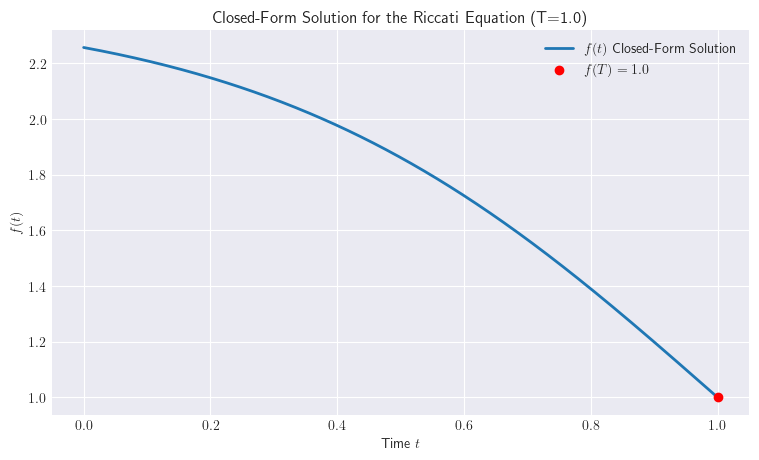

--- Solution Details ---
Root $\lambda_1$: 0.4142
Root $\lambda_2$: -2.4142
Constant Ratio C (C1/C2): 0.0591
Value at t=0: f(0) = 2.2564


In [22]:
import numpy as np
import matplotlib.pyplot as plt

class RiccatiSolver:
    """
    Solves the Riccati equation f'(t) = (kappa^2 / A) * f^2 - 2*gamma*f - a
    in closed form using the transformation to a linear second-order ODE.
    The solution is integrated backward from the terminal condition f(T)=alpha.
    """
    def __init__(self, gamma, kappa, A, a, T, alpha):
        self.gamma = gamma
        self.kappa = kappa
        self.A = A
        self.a = a
        self.T = T
        self.alpha = alpha
        
        # Calculate roots and the integration ratio C = C1 / C2
        self._calculate_constants()

    def _calculate_constants(self):
        """Calculates the characteristic roots (lambda_1, lambda_2) and the
        integration constant ratio C (C1/C2) based on f(T)=alpha."""
        
        # 1. Calculate the discriminant part 'k'
        discriminant_term = self.gamma**2 + (self.a * self.kappa**2) / self.A
        
        if discriminant_term < 0:
            raise ValueError("Discriminant is negative. The solution is oscillatory, not generally solvable in real closed-form (requires complex roots).")
            
        k = np.sqrt(discriminant_term)
        
        # 2. Calculate the characteristic roots: lambda_1 and lambda_2
        self.lambda1 = -self.gamma + k
        self.lambda2 = -self.gamma - k
        
        # 3. Calculate the ratio C = C1 / C2 using the terminal condition f(T)=alpha
        # The general solution is f(t) = -(A/kappa^2) * (C*lambda1*e^(lambda1*t) + lambda2*e^(lambda2*t)) / (C*e^(lambda1*t) + e^(lambda2*t))
        # Solving for C from f(T) = alpha:
        
        # Denominator terms in the equation for C:
        term1_denom = self.alpha + (self.A / self.kappa**2) * self.lambda1
        term2_denom = self.alpha + (self.A / self.kappa**2) * self.lambda2
        
        # Check for division by zero (occurs if alpha = -A/kappa^2 * lambda1)
        if np.isclose(term1_denom, 0):
            raise ValueError(f"The terminal condition alpha={self.alpha} is a critical singular point. The solution for C is undefined.")
        
        # Ratio C = C1 / C2
        # C = - (term2_denom / term1_denom) * exp((lambda2 - lambda1) * T)
        self.C = -(term2_denom / term1_denom) * np.exp((self.lambda2 - self.lambda1) * self.T)

    def f_t(self, t):
        """
        Calculates the value of f(t) using the closed-form solution.
        t can be a scalar or a NumPy array.
        """
        if isinstance(t, np.ndarray) and np.any(t > self.T) or (isinstance(t, (float, int)) and t > self.T):
             print(f"Warning: Time t={t} is outside the defined interval [0, {self.T}].")

        # Numerator: C * lambda1 * exp(lambda1*t) + lambda2 * exp(lambda2*t)
        numerator = (self.C * self.lambda1 * np.exp(self.lambda1 * t) + 
                     self.lambda2 * np.exp(self.lambda2 * t))
        
        # Denominator: C * exp(lambda1*t) + exp(lambda2*t)
        denominator = (self.C * np.exp(self.lambda1 * t) + 
                       np.exp(self.lambda2 * t))
        
        # Final solution: f(t) = -(A/kappa^2) * (Numerator / Denominator)
        f = -(self.A / self.kappa**2) * (numerator / denominator)
        return f

# --- Example Usage and Plotting ---

# Constants (Using placeholder values from previous examples)
CONSTANTS = {
    'gamma': 1.0,
    'kappa': -1.0,
    'A': 1.0,
    'a': 1.0,
    'T': 1.0,
}
INITIAL_CONDITIONS = {
    'alpha': 1.0, # f(T)
}

# 1. Initialize the solver
try:
    riccati_solver = RiccatiSolver(
        CONSTANTS['gamma'], 
        CONSTANTS['kappa'], 
        CONSTANTS['A'], 
        CONSTANTS['a'], 
        CONSTANTS['T'], 
        INITIAL_CONDITIONS['alpha']
    )
except ValueError as e:
    print(f"Error initializing solver: {e}")
    exit()

# 2. Generate time points and calculate f(t)
t_values = np.linspace(0, CONSTANTS['T'], 500)
f_values = riccati_solver.f_t(t_values)

# 3. Plot the result
plt.figure(figsize=(9, 5))
plt.plot(t_values, f_values, label='$f(t)$ Closed-Form Solution', color='#1f77b4', linewidth=2)
plt.scatter(CONSTANTS['T'], INITIAL_CONDITIONS['alpha'], color='red', zorder=5, 
            label=f'$f(T)={INITIAL_CONDITIONS["alpha"]}$')
plt.xlabel('Time $t$')
plt.ylabel('$f(t)$')
plt.title(f'Closed-Form Solution for the Riccati Equation (T={CONSTANTS["T"]})')
plt.grid(True)
plt.legend()
plt.show()

print("--- Solution Details ---")
print(f"Root $\lambda_1$: {riccati_solver.lambda1:.4f}")
print(f"Root $\lambda_2$: {riccati_solver.lambda2:.4f}")
print(f"Constant Ratio C (C1/C2): {riccati_solver.C:.4f}")
print(f"Value at t=0: f(0) = {f_values[0]:.4f}")


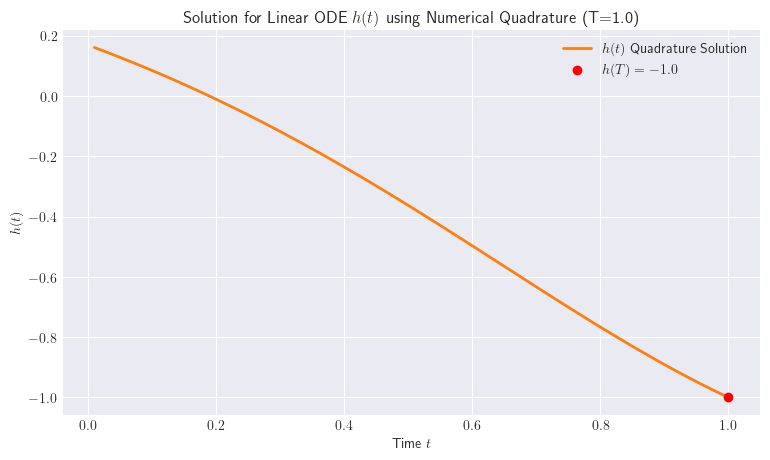

--- Solution Details ---
Value at t=0.01: h(0.01) = 0.1612
Value at t=T: h(T) = -1.0000


In [25]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt

# --- 1. Riccati Solver (Required Input for h(t) Solution) ---

class RiccatiSolver:
    """
    Solves the Riccati equation f'(t) in closed form.
    This provides the necessary f(t) function for the h(t) solver.
    """
    def __init__(self, gamma, kappa, A, a, T, alpha):
        self.gamma = gamma
        self.kappa = kappa
        self.A = A
        self.a = a
        self.T = T
        self.alpha = alpha
        self._calculate_constants()

    def _calculate_constants(self):
        """Calculates roots and the integration ratio C = C1 / C2."""
        discriminant_term = self.gamma**2 + (self.a * self.kappa**2) / self.A
        if discriminant_term < 0:
            raise ValueError("Discriminant is negative.")
            
        k = np.sqrt(discriminant_term)
        self.lambda1 = -self.gamma + k
        self.lambda2 = -self.gamma - k
        
        term1_denom = self.alpha + (self.A / self.kappa**2) * self.lambda1
        term2_denom = self.alpha + (self.A / self.kappa**2) * self.lambda2
        
        self.C = -(term2_denom / term1_denom) * np.exp((self.lambda2 - self.lambda1) * self.T)

    def f_t(self, t):
        """Calculates the value of f(t)."""
        numerator = (self.C * self.lambda1 * np.exp(self.lambda1 * t) + 
                     self.lambda2 * np.exp(self.lambda2 * t))
        denominator = (self.C * np.exp(self.lambda1 * t) + 
                       np.exp(self.lambda2 * t))
        f = -(self.A / self.kappa**2) * (numerator / denominator)
        return f

# --- 2. Linear H Solver (Using Quadrature) ---

class LinearHSolver:
    """
    Solves the linear ODE for h(t) by evaluating the integral solution backward
    from the terminal condition h(T)=beta.
    
    The solution is: h(t) = mu(t) * [ beta - integral_{t}^{T} (Q(tau) / mu(tau)) dtau ]
    where mu(t) is the integrating factor.
    """
    def __init__(self, f_func, gamma, kappa, A, B, b, T, beta):
        self.f_func = f_func  # The solution f(t) from Riccati solver
        self.gamma = gamma
        self.kappa = kappa
        self.A = A
        self.B = B
        self.b = b
        self.T = T
        self.beta = beta
        
    def P(self, t):
        """Coefficient function P(t) = gamma - (kappa^2 / A) * f(t)"""
        return self.gamma - (self.kappa**2 / self.A) * self.f_func(t)

    def Q(self, t):
        """Source function Q(t) = (B*kappa / A) * f(t) - b"""
        return (self.B * self.kappa / self.A) * self.f_func(t) - self.b
    
    def _inner_integral_exponent(self, t, upper_limit):
        """
        Evaluates the definite integral: I_P = integral_{t}^{upper_limit} P(s) ds
        This is used for calculating the integrating factor mu.
        """
        # The quad function returns (integral_value, error_estimate)
        integral_val, _ = quad(self.P, t, upper_limit)
        return integral_val

    def mu(self, t):
        """
        Calculates the Integrating Factor mu(t) = exp(integral_{t}^{T} P(tau) dtau)
        """
        I_P = self._inner_integral_exponent(t, self.T)
        return np.exp(I_P)
    
    def _outer_integrand(self, tau):
        """
        Calculates the integrand for the outer integral: Q(tau) * exp(-integral_{tau}^{T} P(s) ds)
        """
        # Exponent: integral_{tau}^{T} P(s) ds
        I_P = self._inner_integral_exponent(tau, self.T)
        
        # Integrand: Q(tau) * (1 / mu(tau))
        return self.Q(tau) * np.exp(-I_P)

    def h_t(self, t):
        """
        Calculates h(t) by evaluating the outer integral from t to T.
        """
        # 1. Calculate the outer integral: I_outer = integral_{t}^{T} Q(tau) / mu(tau) dtau
        I_outer, _ = quad(self._outer_integrand, t, self.T)
        
        # 2. Calculate the integrating factor mu(t)
        mu_t = self.mu(t)
        
        # 3. Final Solution: h(t) = mu(t) * [ beta - I_outer ]
        return mu_t * (self.beta - I_outer)

# --- Example Usage and Plotting ---

# Constants and Initial Conditions
CONSTANTS = {
    'gamma': 1.0,
    'kappa': -1.0,
    'A': 1.0,
    'a': 1.0,
    'B': 0.0,
    'b': 1.0,
    'T': 1.0,
}
INITIAL_CONDITIONS = {
    'alpha': 1.0, # f(T)
    'beta': -1.0,  # h(T)
}

# 1. Solve for f(t)
f_solver = RiccatiSolver(
    CONSTANTS['gamma'], CONSTANTS['kappa'], CONSTANTS['A'], CONSTANTS['a'], 
    CONSTANTS['T'], INITIAL_CONDITIONS['alpha']
)

# 2. Solve for h(t)
h_solver = LinearHSolver(
    f_solver.f_t, CONSTANTS['gamma'], CONSTANTS['kappa'], CONSTANTS['A'], 
    CONSTANTS['B'], CONSTANTS['b'], CONSTANTS['T'], INITIAL_CONDITIONS['beta']
)

# 3. Generate time points and calculate h(t)
t_values = np.linspace(0.01, CONSTANTS['T'], 100) # Start slightly above 0 to avoid potential numerical issues at the boundary
h_values = np.array([h_solver.h_t(t) for t in t_values])

# 4. Plot the result
plt.figure(figsize=(9, 5))
plt.plot(t_values, h_values, label='$h(t)$ Quadrature Solution', color='#ff7f0e', linewidth=2)
plt.scatter(CONSTANTS['T'], INITIAL_CONDITIONS['beta'], color='red', zorder=5, 
            label=f'$h(T)={INITIAL_CONDITIONS["beta"]}$')
plt.xlabel('Time $t$')
plt.ylabel('$h(t)$')
plt.title(f'Solution for Linear ODE $h(t)$ using Numerical Quadrature (T={CONSTANTS["T"]})')
plt.grid(True)
plt.legend()
plt.show()

print("--- Solution Details ---")
print(f"Value at t=0.01: h(0.01) = {h_values[0]:.4f}")
print(f"Value at t=T: h(T) = {h_values[-1]:.4f}")

<>:177: SyntaxWarning: invalid escape sequence '\e'
<>:178: SyntaxWarning: invalid escape sequence '\e'
<>:179: SyntaxWarning: invalid escape sequence '\e'
<>:182: SyntaxWarning: invalid escape sequence '\e'
<>:177: SyntaxWarning: invalid escape sequence '\e'
<>:178: SyntaxWarning: invalid escape sequence '\e'
<>:179: SyntaxWarning: invalid escape sequence '\e'
<>:182: SyntaxWarning: invalid escape sequence '\e'
/var/folders/9f/dlwft6dn7hxg65r7xqyxvk6r0000gn/T/ipykernel_2392/3533297135.py:177: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(t_values, ell_values, label='$\ell(t)$', color='#2ca02c', linewidth=2)
/var/folders/9f/dlwft6dn7hxg65r7xqyxvk6r0000gn/T/ipykernel_2392/3533297135.py:178: SyntaxWarning: invalid escape sequence '\e'
  plt.scatter(CONSTANTS['T'], 0, color='red', zorder=5, label='$\ell(T)=0$')
/var/folders/9f/dlwft6dn7hxg65r7xqyxvk6r0000gn/T/ipykernel_2392/3533297135.py:179: SyntaxWarning: invalid escape sequence '\e'
  plt.title('Solution for $\ell(t)$ (Quadrat

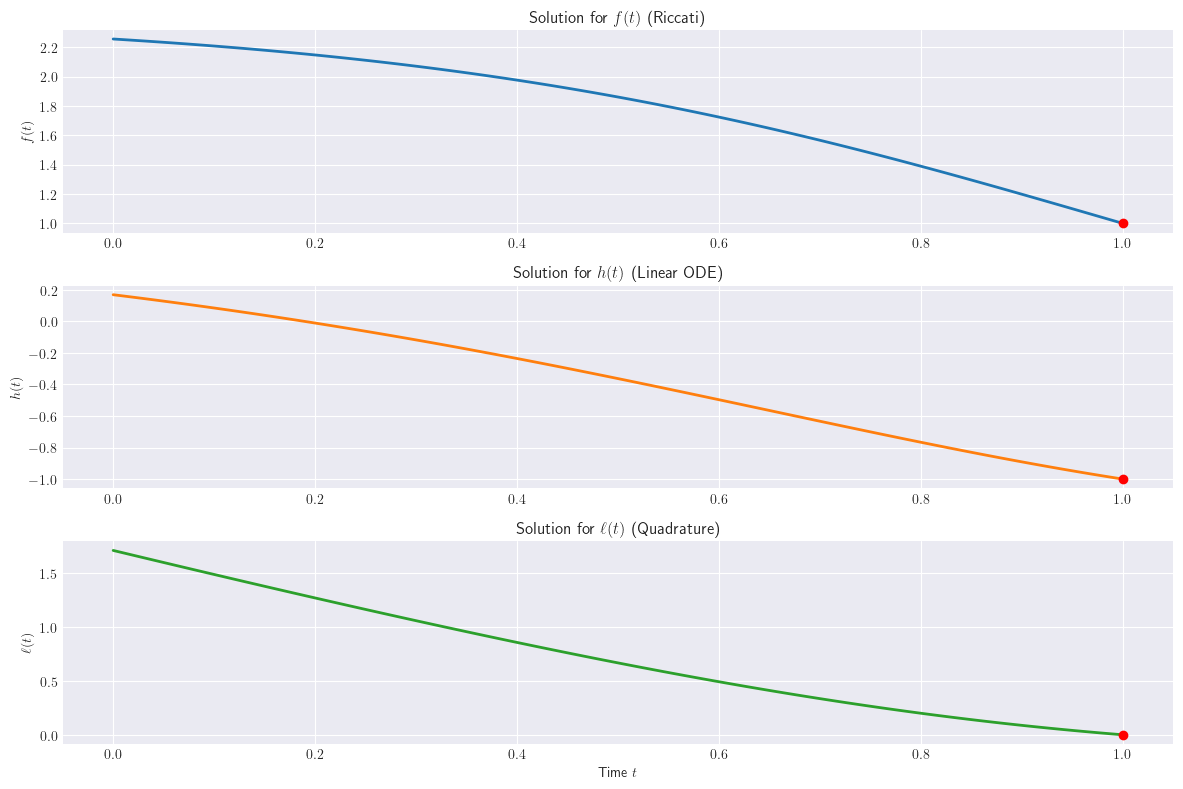

--- Final Calculated Values (t=0) ---
f(0) = 2.2564
h(0) = 0.1691
ell(0) = 1.7102


In [27]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt

# --- 1. Riccati Solver for f(t) (Analytical Closed-Form) ---

class RiccatiFSolver:
    """Solves the Riccati equation f'(t) in closed form to provide f(t)."""
    def __init__(self, gamma, kappa, A, a, T, alpha):
        self.gamma = gamma
        self.kappa = kappa
        self.A = A
        self.a = a
        self.T = T
        self.alpha = alpha
        self._calculate_constants()

    def _calculate_constants(self):
        """Calculates the characteristic roots (lambda_1, lambda_2) and the integration constant ratio C."""
        discriminant_term = self.gamma**2 + (self.a * self.kappa**2) / self.A
        if discriminant_term < 0:
            # Handle complex roots scenario if needed, but for real solutions:
            raise ValueError("Discriminant is negative. Solution requires complex analysis.")
            
        k = np.sqrt(discriminant_term)
        self.lambda1 = -self.gamma + k
        self.lambda2 = -self.gamma - k
        
        term1_denom = self.alpha + (self.A / self.kappa**2) * self.lambda1
        term2_denom = self.alpha + (self.A / self.kappa**2) * self.lambda2
        
        # C = C1 / C2 ratio
        self.C = -(term2_denom / term1_denom) * np.exp((self.lambda2 - self.lambda1) * self.T)

    def f_t(self, t):
        """Calculates the value of f(t) using the closed-form solution."""
        numerator = (self.C * self.lambda1 * np.exp(self.lambda1 * t) + 
                     self.lambda2 * np.exp(self.lambda2 * t))
        denominator = (self.C * np.exp(self.lambda1 * t) + 
                       np.exp(self.lambda2 * t))
        f = -(self.A / self.kappa**2) * (numerator / denominator)
        return f

# --- 2. Linear H Solver (Quadrature Dependent on f(t)) ---

class LinearHSolver:
    """Solves the linear ODE for h(t) by evaluating its integral solution."""
    def __init__(self, f_func, gamma, kappa, A, B, b, T, beta):
        self.f_func = f_func
        self.gamma = gamma
        self.kappa = kappa
        self.A = A
        self.B = B
        self.b = b
        self.T = T
        self.beta = beta
        
    def P(self, t):
        """P(t) = gamma - (kappa^2 / A) * f(t)"""
        return self.gamma - (self.kappa**2 / self.A) * self.f_func(t)

    def Q(self, t):
        """Q(t) = (B*kappa / A) * f(t) - b"""
        return (self.B * self.kappa / self.A) * self.f_func(t) - self.b
    
    def _inner_integral_exponent(self, t, upper_limit):
        """Evaluates I_P = integral_{t}^{upper_limit} P(s) ds"""
        integral_val, _ = quad(self.P, t, upper_limit)
        return integral_val

    def mu(self, t):
        """Integrating Factor mu(t) = exp(integral_{t}^{T} P(tau) dtau)"""
        I_P = self._inner_integral_exponent(t, self.T)
        return np.exp(I_P)
    
    def _outer_integrand(self, tau):
        """Integrand for the outer integral: Q(tau) / mu(tau)"""
        I_P = self._inner_integral_exponent(tau, self.T)
        return self.Q(tau) * np.exp(-I_P)

    def h_t(self, t):
        """Calculates h(t) using the integral formula: h(t) = mu(t) * [ beta - integral_{t}^{T} (Q(tau) / mu(tau)) dtau ]"""
        I_outer, _ = quad(self._outer_integrand, t, self.T)
        mu_t = self.mu(t)
        return mu_t * (self.beta - I_outer)

# --- 3. Ell Solver for ell(t) (Quadrature Dependent on f(t) and h(t)) ---

class EllSolver:
    """
    Solves for ell(t) using quadrature: 
    ell(t) = -integral_{t}^{T} [ ( (B + kappa*h(tau))^2 / 4A ) - sigma^2*f(tau) ] dtau
    """
    def __init__(self, f_func, h_func, kappa, A, B, sigma, T):
        self.f_func = f_func
        self.h_func = h_func
        self.kappa = kappa
        self.A = A
        self.B = B
        self.sigma = sigma
        self.T = T

    def _ell_integrand(self, tau):
        """The function to be integrated (the negative of ell'(t))."""
        f_val = self.f_func(tau)
        h_val = self.h_func(tau)
        
        # Quadratic term: 1/(4A) * (B + kappa*h(tau))^2
        quad_term = (self.B + self.kappa * h_val)**2 / (4 * self.A)
        
        # Integrand: quad_term - sigma^2 * f(tau)
        return quad_term - (self.sigma**2 * f_val)

    def ell_t(self, t):
        """
        Calculates ell(t) by evaluating the definite integral from t to T.
        """
        # I_ell = integral_{t}^{T} [ (B + kappa*h)^2 / 4A - sigma^2*f ] dtau
        I_ell, _ = quad(self._ell_integrand, t, self.T)
        
        # Final Solution: ell(t) = -I_ell (since ell(T)=0)
        return -I_ell

# --- Example Usage and Plotting ---

# Parameters
CONSTANTS = {
    'gamma': 1.0, 'kappa': -1.0, 'A': 1.0, 'a': 1.0, 
    'B': 0.0, 'b': 1.0, 'sigma': 1.0, 'T': 1.0,
}
TERMINAL_CONDITIONS = {
    'alpha': 1.0, # f(T)
    'beta': -1.0,  # h(T)
}

# 1. Initialize Solvers
f_solver = RiccatiFSolver(
    CONSTANTS['gamma'], CONSTANTS['kappa'], CONSTANTS['A'], CONSTANTS['a'], 
    CONSTANTS['T'], TERMINAL_CONDITIONS['alpha']
)
h_solver = LinearHSolver(
    f_solver.f_t, CONSTANTS['gamma'], CONSTANTS['kappa'], CONSTANTS['A'], 
    CONSTANTS['B'], CONSTANTS['b'], CONSTANTS['T'], TERMINAL_CONDITIONS['beta']
)
ell_solver = EllSolver(
    f_solver.f_t, h_solver.h_t, CONSTANTS['kappa'], CONSTANTS['A'], 
    CONSTANTS['B'], CONSTANTS['sigma'], CONSTANTS['T']
)

# 2. Generate Time Points
# Note: Integration can be computationally intensive, so we use a reasonable number of points (100)
t_values = np.linspace(0.0, CONSTANTS['T'], 100)

# 3. Calculate all three solutions
f_values = f_solver.f_t(t_values)
h_values = np.array([h_solver.h_t(t) for t in t_values])
ell_values = np.array([ell_solver.ell_t(t) for t in t_values])

# 4. Plot the results
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t_values, f_values, label='$f(t)$', color='#1f77b4', linewidth=2)
plt.scatter(CONSTANTS['T'], TERMINAL_CONDITIONS['alpha'], color='red', zorder=5)
plt.title('Solution for $f(t)$ (Riccati)')
plt.grid(True)
plt.ylabel('$f(t)$')

plt.subplot(3, 1, 2)
plt.plot(t_values, h_values, label='$h(t)$', color='#ff7f0e', linewidth=2)
plt.scatter(CONSTANTS['T'], TERMINAL_CONDITIONS['beta'], color='red', zorder=5)
plt.title('Solution for $h(t)$ (Linear ODE)')
plt.grid(True)
plt.ylabel('$h(t)$')

plt.subplot(3, 1, 3)
plt.plot(t_values, ell_values, label='$\ell(t)$', color='#2ca02c', linewidth=2)
plt.scatter(CONSTANTS['T'], 0, color='red', zorder=5, label='$\ell(T)=0$')
plt.title('Solution for $\ell(t)$ (Quadrature)')
plt.grid(True)
plt.xlabel('Time $t$')
plt.ylabel('$\ell(t)$')

plt.tight_layout()
plt.show() 

print("--- Final Calculated Values (t=0) ---")
print(f"f(0) = {f_values[0]:.4f}")
print(f"h(0) = {h_values[0]:.4f}")
print(f"ell(0) = {ell_values[0]:.4f}")
